# Setup inicial

In [99]:
# Paths & URLs

import os

# Directorio base
#PATH_BASE = '/content/drive/MyDrive/proximity'
#PATH_BASE = 'C:\\Users\\User\\Documents\\Proyecto Proximity'
PATH_BASE = 'E:\\files\\Documents\\Proyecto Proximity'
#PATH_BASE = '/dataChivo/batch_01/bigdata_02/datareleases/'
USER_HOME_PATH = 'E:\\files\\Documents\\Proyecto Proximity'
#USER_HOME_PATH = '/dataChivo/jpmunoz/'

# Data release 70
DATA_RELEASE_PATH = os.path.join(PATH_BASE, 'datalake_sorted')
DR70_PATH = os.path.join(PATH_BASE, 'DR70')
DR70_LABELS_PATH = os.path.join(DR70_PATH, 'labels.csv')

# Data release 217
DR217_PATH = os.path.join(PATH_BASE, 'DR217')
DR217_CT_PATH = os.path.join(DR217_PATH, 'DR217_studies')
# Used for normalization of the intensity values for each CT
DR217_CT_HISTOGRAM_LANDMARKS_PATH = os.path.join(DR217_PATH, 'DR217_histogram_landmarks.npy')
DR217_LABELS_PATH = os.path.join(DR217_PATH, 'DR217_labels.csv')
# Embeddings ResNet18 DR217
DR217_RESNET_EMBEDDINGS_PATH = os.path.join(DR217_PATH, 'DR217_resnet18_embeddings_v2')
DR217_PREPROCESSED_PATH = os.path.join(DR217_PATH, 'DR217_preprocessed')
DR217_PREPROCESSED_DOWNSIZED_PATH = os.path.join(DR217_PATH, 'DR217_preprocessed_downsized')


# Data release 2156
# DR2156_DATARELEASE_PATH = os.path.join(PATH_BASE, 'DR2156')
# DR2156_DATARELEASE_CT_PATH = os.path.join(DR2156_DATARELEASE_PATH, 'DR2156_studies')
# DR2156_DATARELEASE_LABELS_PATH = os.path.join(DR2156_DATARELEASE_PATH, 'DR2156_labels', 'DR2156_labels.csv')


#DR2156_DATARELEASE_PATH = os.path.join(USER_HOME_PATH, 'chest_ct_retrieval', 'data', 'DR2156', 'DR2156_DICOM')
DR2156_DATARELEASE_PATH = os.path.join(PATH_BASE, 'chest_ct_retrieval', 'data', 'DR2156')
DR2156_DATARELEASE_CT_PATH = os.path.join(DR2156_DATARELEASE_PATH, 'DR2156_DICOM', 'DR2156_studies')
DR2156_DATARELEASE_LABELS_PATH = os.path.join(DR2156_DATARELEASE_PATH, 'DR2156_DICOM', 'DR2156_labels', 'DR2156_labels.csv')
# Embeddings ResNet18 DR2156 con dimensiones 300x300x300
DR2156_300_RESNET_EMBEDDINGS_PATH = os.path.join(PATH_BASE, 'chest_ct_retrieval', 'data', 'DR2156', 'DR2156_300_resnet18_embeddings')
DR2156_300_PREPROCESSED_PATH = os.path.join(PATH_BASE, 'chest_ct_retrieval', 'data', 'DR2156', 'DR2156_300_preprocessed')
DR2156_300_PREPROCESSED_ZARR_PATH = os.path.join(PATH_BASE, 'chest_ct_retrieval', 'data', 'DR2156', 'DR2156_300_preprocessed_zarr')
DR2156_300_PREPROCESSED_INT8_PATH = os.path.join(USER_HOME_PATH, 'chest_ct_retrieval', 'data', 'DR2156', 'DR2156_300_preprocessed_int8')

# Embeddings ResNet18 DR2156 con dimensiones 512x512x300
DR2156_512_RESNET_EMBEDDINGS_PATH = os.path.join(USER_HOME_PATH, 'experimentos', 'datasets', 'DR2156', 'DR2156_512_resnet18_embeddings')
DR2156_512_PREPROCESSED_PATH = os.path.join(USER_HOME_PATH, 'experimentos', 'datasets', 'DR2156', 'DR2156_512_preprocessed')


DR2156_270_PREPROCESSED_UINT8_PATH = os.path.join(USER_HOME_PATH, 'chest_ct_retrieval', 'data', 'DR2156', 'DR2156_270_preprocessed_uint8')

# CTs in Nibabel format
CT_NIBABEL_PATH = os.path.join(PATH_BASE, 'DR70', 'CTs')
CT_NIBABEL_ZERO_PADDED_PATH = os.path.join(PATH_BASE, 'DR70', 'CTs', 'zero_padded')

# Embeddings visuales de CTs
CT_EMBEDDINGS_PATH = DATA_RELEASE_PATH + '/visual_embeddings'


# Etiquetas de los CTs del data release actual
#CT_LABELS_CSV_PATH = DATA_RELEASE_PATH + '/labels.csv'

# Data release (CTs + etiquetas) organizados en un DataFrame
CT_DATASET_DF_HDF_PATH = os.path.join(PATH_BASE, 'dataset_df.h5')
CT_DATASET_DF_PICKLE_PATH = os.path.join(PATH_BASE, 'dataset_df.pickle')

# URLs de modelos visuales
RESNET18_URL = 'microsoft/resnet-18'

# Path que contiene los resnet50 embeddings de CTs del data release actual
CT_RESNET18_EMBEDDINGS_PATH = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18')
CT_RESNET18_EMBEDDINGS_PATH_ZERO_PADDED = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18', 'zero_padded')
CT_RESNET18_EMBEDDINGS_PATH_NN_INTERPOLATED = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18', 'nn_interpolated')

In [100]:
import os
import pandas as pd
import numpy as np
import torch
import torchio as tio
from torch.utils.data import Dataset, random_split, RandomSampler, BatchSampler
from scipy.spatial.distance import hamming
import random
import logging

# Set seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
#torch.cuda.manual_seed(0)
#torch.cuda.manual_seed_all(0)

logging.basicConfig(level=logging.INFO)

class ProximityCTDataset(tio.SubjectsDataset):
    def __init__(self, ct_base_path, ct_image_ids, ct_labels_path, histogram_landmarks=None):
        
        self.ct_dir_list = [os.path.join(ct_base_path, ct) for ct in ct_image_ids]

        self.labels_df = pd.read_csv(
            ct_labels_path, 
            header=0, 
            index_col=0, 
            dtype={'CT': str, 'condensacion': int, 'nodulos': int, 'quistes': int}
        )
        
        # Mark those samples that have non-binary label values as not valid
        #self.labels_df['labels_are_valid'] = self.labels_df.apply(self._determine_valid_labels, axis=1)
        self.labels_df['labels_are_valid'] = True
        self.labels_df = self.labels_df.replace(to_replace=9, value=0)

        s_list = []
        #for s_id in ct_image_ids:
        for (s_dir, s_id) in zip(self.ct_dir_list, ct_image_ids):
            #print('Procesando: ' + s_id)
            label_attribs = self._get_ct_label_data(s_id)
            s = tio.Subject(
                t1 = tio.ScalarImage(os.path.join(ct_base_path, s_id)),
                #image_path = os.path.join(ct_base_path, s_id),
                image_path = s_dir,
                name = s_id,
                **label_attribs
            )
            s_list.append(s)

        # Transforms and augmentations to apply to images in the dataset
        s_transforms = tio.Compose([
            tio.ToCanonical(),
            tio.Resample(1),
            tio.CropOrPad(target_shape=(270, 270, 300), padding_mode='constant'),
            tio.Clamp(out_min=-1000, out_max=200), #Clip Hounsfield units
            tio.RescaleIntensity(out_min_max=(0, 255)),
        ])

        # Filter out those samples with invalid labels
        s_list = [s for s in s_list if s['labels_are_valid']]
        
        super().__init__(s_list, transform=s_transforms, load_getitem=False)
        
    def _determine_valid_labels(self, row):
        if (row['condensacion'] == 1 or row['condensacion'] == 0) \
        and (row['nodulos'] == 1 or row['nodulos'] == 0) \
        and (row['quistes'] == 1 or row['quistes'] == 0):
            return True
        return False

    def _get_ct_label_data(self, ct_code):
        #result = self.labels_df.loc[self.labels_df['CT'] == ct_code+'AN'].to_dict('records')
        result = self.labels_df.loc[self.labels_df['CT'] == ct_code].to_dict('records')
        if result:
            r = result[0]
            r['labels_as_vector'] = self._get_label_vector(r)
            return r
        else:
            return {'labels_are_valid': False}

    def _get_label_vector(self, labels_dict):
        c = int(labels_dict['condensacion'])
        n = int(labels_dict['nodulos'])
        q = int(labels_dict['quistes'])
        no_anomalies = int(not 1 in [c, n, q])
        return [no_anomalies, c, n, q]

In [101]:
import random

subject_list = [dirname for dirname in os.listdir(DR2156_DATARELEASE_CT_PATH)]

subject_subset = random.sample(subject_list, 5)

dataset = ProximityCTDataset(DR2156_DATARELEASE_CT_PATH, subject_list, DR2156_DATARELEASE_LABELS_PATH)

In [42]:
dataset[2]['t1'].affine

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.59500000e+02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         5.00000000e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        -5.65253676e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [27]:
dataset[2]["t1"]["data"].shape

torch.Size([1, 448, 448, 300])

torch.Size([300, 270, 270])
tensor([[[-5.8687e-03,  1.2503e-02, -7.7289e-03,  ...,  2.4940e-03,
          -1.8160e-03,  2.8834e-03],
         [-2.4401e-02,  8.6791e-03, -1.1637e-02,  ..., -6.9926e-03,
          -1.0910e-02,  7.6738e-03],
         [-3.1503e-03, -1.6726e-02, -7.4173e-03,  ..., -2.8986e-03,
          -1.4963e-02,  7.9095e-03],
         ...,
         [-3.1592e-03,  4.0342e-03,  1.8404e-03,  ...,  3.5402e-03,
          -1.5461e-03, -4.4827e-03],
         [-6.2692e-03, -3.4366e-03,  1.3864e-02,  ..., -8.4764e-03,
           2.8175e-03, -3.5262e-03],
         [-1.2724e-02, -2.2788e-03, -1.5444e-03,  ...,  4.6249e-03,
           4.4147e-03,  4.1936e-03]],

        [[-1.2447e-02, -1.2231e-03,  2.4057e-03,  ..., -1.2293e-02,
           1.7512e-02,  2.9164e-03],
         [ 7.2446e-03, -3.9416e-03, -1.7617e-03,  ..., -1.0340e-02,
          -1.1965e-03, -3.3190e-03],
         [-7.6639e-03, -9.2753e-03, -1.2509e-02,  ..., -8.4861e-03,
           4.7255e-03,  2.6101e-03],
         ..

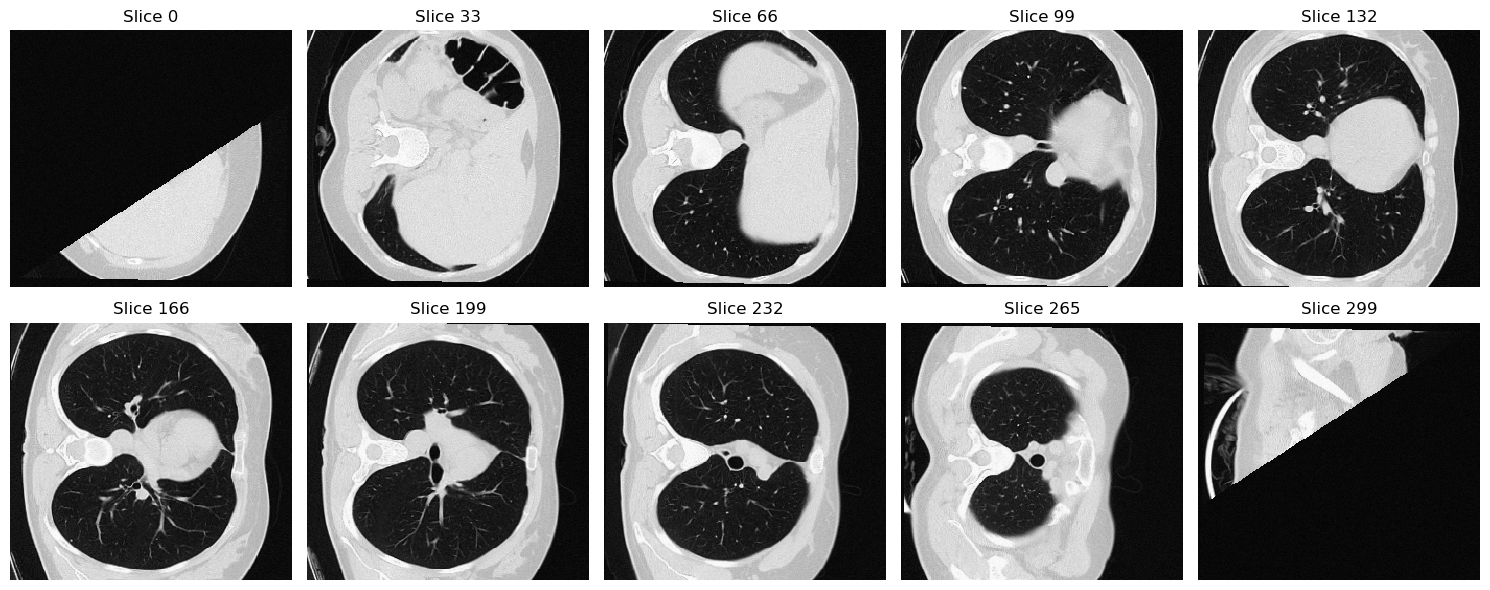

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torchio as tio

s_vol = dataset[938]

s_vol

s_vol = np.transpose(dataset[2]["t1"]["data"], axes=[0, 3, 1, 2]) # transpose [D, 1, H, W] to [1, D, H, W]

# Get the 3D volume from the TorchIO subject
resize = tio.Compose([
            #tio.Resize([100, 100, -1], image_interpolation='nearest'),
            tio.RescaleIntensity(out_min_max=(0,1)),
            tio.RandomAffine(scales=(0.95, 1.05), degrees=5, p=0.5),
            tio.RandomNoise(mean=0, std=(0, 0.01), p=0.5),
        ])

tio_image = tio.ScalarImage(tensor=s_vol, affine=np.eye(4))
tio_image = resize(tio_image)                

s_vol = tio_image['data'][0]           # remove channel dimension → shape: [D, H, W]

depth = s_vol.shape[0]

print(s_vol.shape)
print(s_vol)

# Select 10 equally spaced indices across the depth axis
n_slices = 10
indices = np.linspace(0, depth - 1, n_slices, dtype=int)

# Plot the selected slices in a grid
cols = 5
rows = (n_slices + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()

for i, idx in enumerate(indices):
    axes[i].imshow(s_vol[idx].numpy(), cmap='gray', aspect='auto', interpolation='none')
    axes[i].set_title(f'Slice {idx}')
    axes[i].axis('off')
    axes[i].set_frame_on(False)  # Remove subplot border

# Hide unused subplots
for ax in axes[n_slices:]:
    ax.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
s = dataset[2]
print(s['t1']['data'][0].shape)
print(torch.min(s['t1']['data'][0]))
print(torch.max(s['t1']['data'][0]))
#print(s['t1']['data'][0])
s.plot(figsize=(10, 30))

In [ ]:
preprocess = tio.Compose([
            tio.Resample(1),
            tio.Resize()
            #tio.RescaleIntensity(out_min_max=(-1, 1)),
        ])

In [4]:
dataset.labels_df.head()

,CT,condensacion,nodulos,quistes,labels_are_valid
0,01003316,0,0,0,True
1,01003335,0,0,0,True
2,01003352,0,1,0,True
3,01003431,0,1,0,True
4,01003686,0,1,0,True


ImageSeriesReader (0x1181ebf0): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.49312



torch.Size([300, 300, 300])
tensor(-1.)
tensor(1.)


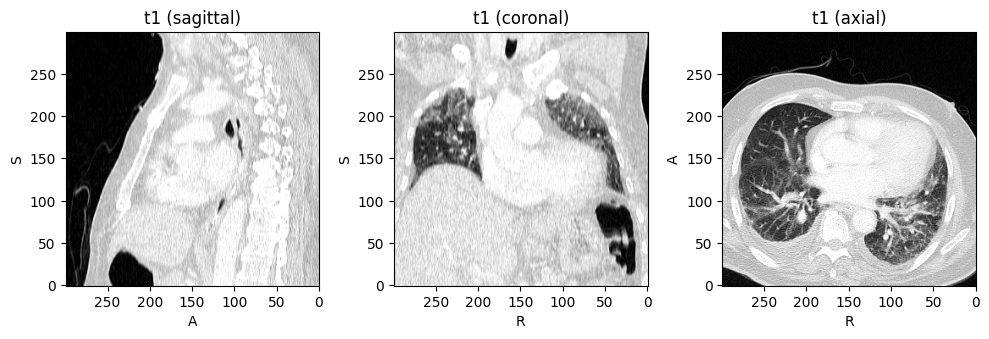

In [5]:
s = dataset[2]

print(s['t1']['data'][0].shape)
print(torch.min(s['t1']['data'][0]))
print(torch.max(s['t1']['data'][0]))
#print(s['t1']['data'][0])
s.plot(figsize=(10, 30))

# Experimentación con normalización por histograma (ignorar, ya que terminé por no aplicarlo)

In [6]:
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.1, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)


fig, ax = plt.subplots(dpi=100)
for s in tqdm(dataset):
    tensor = s['t1']['data']
    #if 'HH' in path.name: color = 'red'
    #elif 'Guys' in path.name: color = 'green'
    #elif 'IOP' in path.name: color = 'blue'
    plot_histogram(ax, tensor)
ax.set_xlim(-1500, 3500)
ax.set_ylim(0, 0.004)
ax.set_title('Original histograms of all samples')
ax.set_xlabel('Intensity')
ax.grid()
graph = None

  0%|          | 0/217 [00:00<?, ?it/s]

In [ ]:
subject_list = [dirname for dirname in os.listdir(DR217_CT_PATH)]
subject_path_list = [os.path.join(DR217_CT_PATH, s_id) for s_id in subject_list]

landmarks = tio.HistogramStandardization.train(
    subject_path_list,
    output_path=DR217_CT_HISTOGRAM_LANDMARKS_PATH,
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

  0%|          | 0/217 [00:00<?, ?it/s]


Trained landmarks: [  0.      2.062   4.523   6.237   8.569  18.213  36.948  53.601  60.422
  62.771  65.159  71.262 100.   ]


  0%|          | 0/5 [00:00<?, ?it/s]

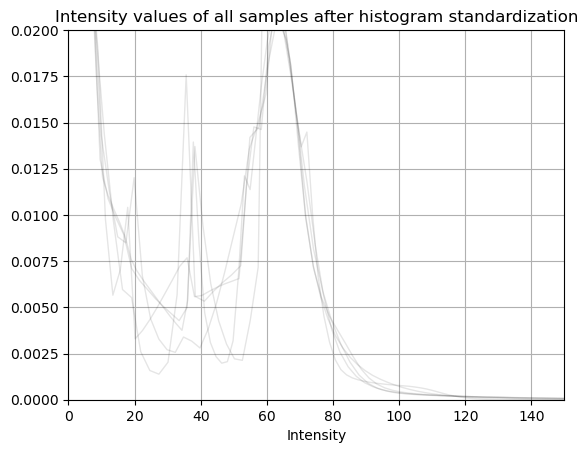

In [ ]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy import stats

landmarks_dict = {'t1': landmarks}
histogram_transform = tio.HistogramStandardization(landmarks_dict)

subject_list = [dirname for dirname in os.listdir(DR217_CT_PATH)]
subject_subset = random.sample(subject_list, 5)
dataset = ProximityCTDataset(DR217_CT_PATH, subject_subset, DR217_LABELS_PATH)


def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.1, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)


fig, ax = plt.subplots(dpi=100)
for i ,sample in enumerate(tqdm(dataset)):
    standard = histogram_transform(sample)
    tensor = standard.t1.data
    #path = str(sample.mri.path)
    #if 'HH' in path: color = 'red'
    #elif 'Guys' in path: color = 'green'
    #elif 'IOP' in path: color = 'blue'
    plot_histogram(ax, tensor)
ax.set_xlim(0, 150)
ax.set_ylim(0, 0.02)
ax.set_title('Intensity values of all samples after histogram standardization')
ax.set_xlabel('Intensity')
ax.grid()
graph = None

[0, 1, 0]
tensor([[[[-1016,  -939,  -941,  ...,  -976, -1003,  -997],
          [ -866,  -787,  -907,  ...,  -913,  -972, -1002],
          [ -874,  -949, -1012,  ...,  -944, -1002, -1011],
          ...,
          [ -979,  -981,  -987,  ...,  -962, -1005,  -960],
          [ -740,  -735,  -883,  ...,  -896,  -987,  -989],
          [ -922,  -951,  -940,  ...,  -760,  -813,  -835]],

         [[-1016, -1000,  -983,  ..., -1003,  -968,  -934],
          [-1018,  -936,  -826,  ...,  -989,  -950,  -935],
          [ -714,  -848,  -853,  ...,  -934,  -883,  -879],
          ...,
          [ -834,  -883,  -939,  ...,  -956,  -993, -1006],
          [ -818,  -835,  -881,  ...,  -876,  -798,  -845],
          [ -974,  -994,  -901,  ...,  -862,  -790,  -752]],

         [[ -825,  -915, -1000,  ...,  -935,  -906,  -978],
          [-1008,  -996, -1019,  ..., -1010, -1007, -1006],
          [-1016,  -968,  -911,  ...,  -985,  -950,  -953],
          ...,
          [ -950,  -902,  -961,  ...,  -8

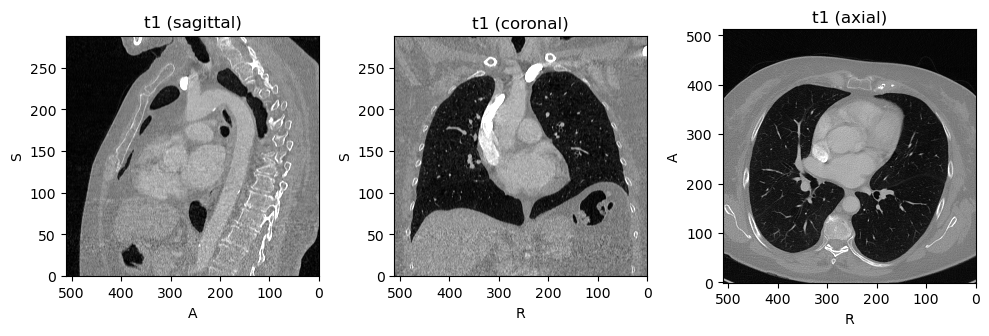

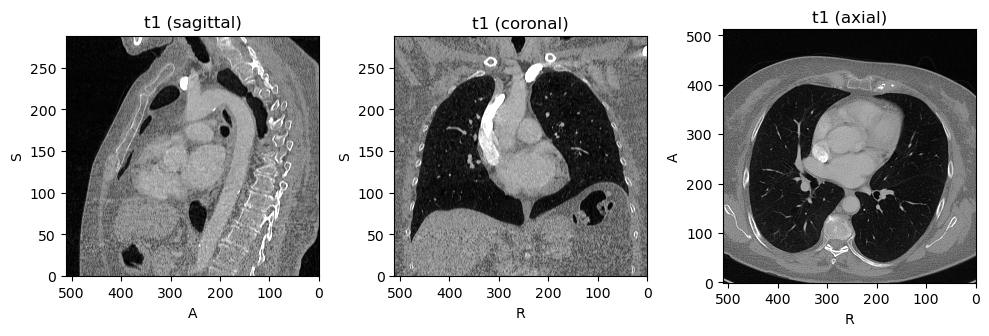

In [ ]:
d = dataset[3]
rescaled_d = tio.RescaleIntensity(out_min_max=(0, 255))(d)
histogramed_d = histogram_transform(d)
print(d['labels_as_vector'])
print(d['t1']['data'])
print(rescaled_d['t1']['data'].int())
rescaled_d.plot(figsize=(10, 30))
histogramed_d.plot(figsize=(10, 30))


# Instanciar modelo ResNet y generar embeddings a partir de los CTs

In [15]:
from torch import nn
from torchvision import models

class CTEmbeddingModel(nn.Module):
    def __init__(self):
        super(CTEmbeddingModel, self).__init__()
        
        resnet = models.resnet18(weights='DEFAULT')
        self.features = nn.Sequential(*(list(resnet.children())[:-2]))

        '''
        #conv input torch.Size([1,83,512,14,14])
        self.reducingconvs = nn.Sequential(
            nn.Conv3d(28, 16, kernel_size = (3,3,3), stride=(3,1,1), padding=0),
            nn.ReLU(),
            
            #nn.Conv3d(16, 8, kernel_size = (3,3,3), stride=(3,1,1), padding=0),
            #nn.ReLU(),
            
            #nn.Conv3d(8, 4, kernel_size = (3,1,1), stride=(3,1,1), padding=0),
            #nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(16*170*3*3, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256), 
            nn.ReLU(True),
            nn.Dropout(0.5),
            
            nn.Linear(256, 2))
        '''
      
    def forward(self, x):
        #print('input shape', x.shape)
        #x = x.permute(0, 3, 1, 2)
        #print(x.shape)
        shape = list(x.size())
        #example shape: [1,83,3,290,290]
        #example shape: [2,83,3,290,290]
        batch_size = int(shape[0])
        x = x.view(batch_size*100,3,300,300)
        x = self.features(x)
        #print('resnet output shape:', x.size())
        '''
        x = x.view(batch_size,28,512,5,5)
        x = self.reducingconvs(x)
        #output is shape [batch_size, 16, 18, 3, 3]
        #print('reducingconvs output shape:', x.size())
        x = x.view(batch_size, 16*170*3*3)
        x = self.fc(x)
        '''
        return x

In [102]:
from torchvision.transforms import v2
from tqdm import tqdm

# model = CTEmbeddingModel()
# model.eval()
# model.cuda()

# input tensor comes in the range [0, 1]
# only remaining steps to complete Z-Normalization for ResNet is substrating the mean of 0.449 and dividing each pixel by the std of 0.226.
transforms_composite = v2.Compose([
    #v2.Grayscale(num_output_channels=1),
    #v2.Resize((100, 100)),
    v2.ToDtype(torch.uint8, scale=False), # with scale=True, scales pixel values from [0, 255] to [0.0, 1.0]
    #v2.Normalize(mean=[0.449], std=[0.226])
])
counter = 0
with torch.no_grad():
    for s in tqdm(dataset):
        counter += 1
        
        input_normalized = transforms_composite(s['t1']['data'].detach().clone())
        number_formatted = '{:04d}'.format(counter)
        labels_formatted = '_'.join([str(l) for l in s['labels_as_vector']])
        name = number_formatted + '_' + s['name'] + '_' + labels_formatted
        #embedding = model(input_normalized.cuda()).cpu().numpy()
        label = np.array(s['labels_as_vector'])
        #np.savez_compressed(os.path.join(DR2156_300_RESNET_EMBEDDINGS_PATH, name), name=name, embedding=embedding, label=label)
        np.savez_compressed(os.path.join(DR2156_270_PREPROCESSED_UINT8_PATH, name), name=name, volume=input_normalized.cpu().numpy().astype(np.uint8), label=label)


100%|██████████| 2156/2156 [3:42:22<00:00,  6.19s/it]  


In [47]:
import numpy as np
import zarr
from numcodecs import Blosc
from pathlib import Path
from torchvision.transforms import v2
from tqdm import tqdm
import shutil

def preprocess_and_save_zarr():
    transforms = v2.Compose([
        v2.Normalize(mean=[0.449], std=[0.226])
    ])

    output_dir = Path(DR2156_300_PREPROCESSED_ZARR_PATH)
    output_dir.mkdir(parents=True, exist_ok=True)

    counter = 0

    for subject in tqdm(dataset):
        counter += 1
        #subject = transforms(subject)

        vol = subject['t1']['data'].squeeze().numpy().astype(np.float16)

        # map from [-1000, 200] Housnfield Units (16-bit per voxel) to [0, 255] pixel range (8-bit per voxel)
        # 256 values over a 1200 HU window → ≈ 4.7 HU per step
        hu_min, hu_max = -1000, 200  # lung/soft tissue window
        scaled = np.clip(vol, hu_min, hu_max)
        scaled = ((scaled - hu_min) / (hu_max - hu_min) * 255).astype(np.uint8)

        number_formatted = f"{counter:04d}"
        labels_formatted = '_'.join(map(str, subject['labels_as_vector']))
        base_name = f"{number_formatted}_{subject['name']}_{labels_formatted}"
        zarr_dir = output_dir / f"{base_name}.zarr"
        zip_path = output_dir / f"{base_name}.zarr.zip"

        # Remove existing files
        if zarr_dir.exists():
            shutil.rmtree(zarr_dir)
        if zip_path.exists():
            zip_path.unlink()

        # Save Zarr directory with compression
        z = zarr.open_array(
            store=zarr_dir,
            mode="w",
            shape=(300, 300, 300),
            dtype="float16",
            chunks=(64, 128, 128),
            compressor=Blosc(cname='zstd', clevel=5, shuffle=Blosc.BITSHUFFLE),
        )
        z[:] = scaled

        # Compress directory into .zip
        shutil.make_archive(base_name=zarr_dir, format='zip', root_dir=zarr_dir)

        # Optionally delete uncompressed Zarr directory
        shutil.rmtree(zarr_dir)


In [48]:
preprocess_and_save_zarr()

100%|████████████████████████████████████████████████████████████████████████████| 2156/2156 [3:38:00<00:00,  6.07s/it]


In [ ]:
del tensor, model, subject  # or any other large variables
import gc
gc.collect()
import torch
torch.cuda.empty_cache()